![](../img/330-banner.png)

Lecture 4: $k$-Nearest Neighbours and SVM RBFs  
------------
UBC 2022-23 W2

Instructor: Amir Abdi

iclicker link: https://join.iclicker.com/EMMJ <img src="img_aa/iclicker_qr_code.png" height="300" width="300"> 

<!--
replace (img/ wih (../img/  
replace https://join.iclicker.com/3DP5H with https://join.iclicker.com/EMMJ
replace "data/ with "../data
copy legends
copy setup cell
-->

## Announcements

- hw2 deadline is Jan 23, 11:59pm
- [Last day to withdraw without a W standing](https://students.ubc.ca/enrolment/dates-deadlines#2022-23-winter-session-term-2): Jan 23, 2023


<br><br>

### Learning outcomes

From this lecture, you will be able to 

- explain the notion of **similarity-based algorithms**; 
- broadly describe how **$k$-NN** use distances; 
- discuss the effect of using a small/large value of the hyperparameter $k$ when using the $k$-NN algorithm; 
- describe the problem of **curse of dimensionality**; 
- explain the general idea of **SVMs** and **RBF kernel**;
  - broadly describe the relation of `gamma` and `C` hyperparameters of SVMs with the fundamental tradeoff.

<br><br>

### Quick recap

After last session you should know the following; if you don't go back and re-read the content:
- **Train/Valid/Test** datasets and how they help you make better predictions on Prod data.
- **Over-fitting** vs. **Under-fitting**
- The **Bias** vs. **Variance** Tradeoff
- **Golden rule of ML** (not look at test data too often)

<img src="https://miro.medium.com/max/1240/1*feFntGUIiob7MwUX62jdCg.webp" height="500" width="500"> 

Source: https://prvnk10.medium.com/bias-variance-tradeoff-ebf13adcea42


Total Error of the model = $Bias_{error} + Variance_{error} + \sigma$ 
- **Bias** of the learning method: error of simplifying assumptions built into the method (e.g. DecisionTree is a simplifying assumption)
- **Variance** of the learning method: How much the learning method will move around its mean **as the data changes**
- **Irreducible error**: When `X` doesn't fully determine `y`

## Legends


    
| <img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/This_is_the_photo_of_Arthur_Samuel.jpg" width="100"> | <img src="http://www.cs.cmu.edu/~tom/TomHead2-6-22-22.jpg" width="100">  | <img src="https://upload.wikimedia.org/wikipedia/commons/4/49/John_McCarthy_Stanford.jpg" width="100"> |
| :-----------: | :-----------: | :-----------: |
| Arthur Samuel       | Tom Mitchell       |John McCarthy|
| (1901-1990)    | 1951 - Now       |  1927 – 2011 |
| First computer learning program | 1997 ML Texbook, CMU Prof | Co-coined term AI, Lisp,<br> Time-sharing, Garbage collection



<br><br>

<br><br>

---------------
If you want to run this notebook you will have to install `ipywidgets`. 
Follow the installation instructions [here](https://ipywidgets.readthedocs.io/en/latest/user_install.html).

---------------

In [1]:
# Setup

# install ipywidgets if not already installed
!pip install ipywidgets

# Some helper functions to save us time
import sys
sys.path.append("../code/.")

import glob
import matplotlib.pyplot as plt
from IPython.display import HTML
import pandas as pd
import numpy as np
import mglearn

plt.rcParams["font.size"] = 16
pd.set_option("display.max_colwidth", 200)

# Motivation and distances [[video](https://youtu.be/hCa3EXEUmQk)]

## Similarity (Analogy)-based models

- Suppose you are given the following training examples with corresponding labels and are asked to label a given test example.

![](../img/knn-motivation.png)
<!-- <img src='./img/knn-motivation.png' width="1000"> -->

source of image: https://vipl.ict.ac.cn/en/database.php

- An intuitive way to classify the test example is by finding the most "similar" example(s) from the training set and using that label for the test example.  

### Analogy-based algorithms in practice

- High-tech Facial Recognition
    - Feature vectors for human faces 
    - $k$-NN to identify which face is on their watch list
- Recommendation systems     
- Modern Machine Learning: Embeddings of a Large Language model (e.g. GPT) to find similar documents to a given document

### General idea of $k$-nearest neighbours algorithm

- Consider the following toy dataset with two classes.
    - blue circles $\rightarrow$ class 0
    - red triangles $\rightarrow$ class 1 
    - green stars $\rightarrow$ test examples

In [2]:
X, y = mglearn.datasets.make_forge()
X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, 0.5]])

/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


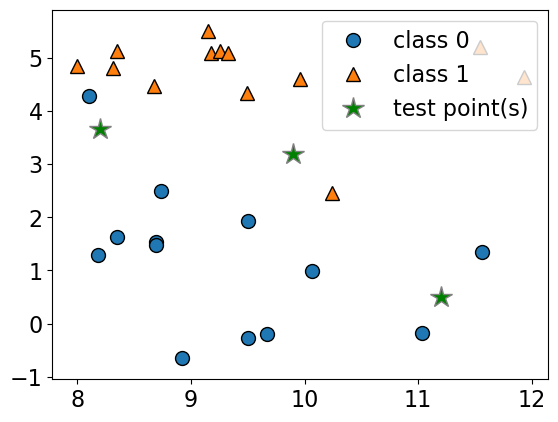

In [3]:
from plotting_functions import plot_train_test_points
plot_train_test_points(X, y, X_test)

- Given a new data point, predict the class of the data point by finding the "**closest**" data point in the training set,   
  - Decide the class based on similarity by finding its "**nearest neighbour**" or 
  - **majority vote** of nearest neighbours. 

In [4]:
from plotting_functions import plot_knn_clf
def f(n_neighbors):
    return plot_knn_clf(X, y, X_test, n_neighbors=n_neighbors)

In [5]:
import ipywidgets as widgets
from ipywidgets import interact, interactive
interactive(
    f,
    n_neighbors=widgets.IntSlider(min=1, max=10, step=2, value=1),
)

interactive(children=(IntSlider(value=1, description='n_neighbors', max=10, min=1, step=2), Output()), _dom_cl…

## Geometric view of features (What is a Dimension?)

- To understand similarity (analogy)-based algorithms it's useful to think of data as points in a high dimensional space. 
- Our `X` represents the problem in terms of relevant **features** ($d$) with one dimension for each **feature** (column).
- Examples are **points in a $d$-dimensional space**. 

How many dimensions (features) are there in the cities data?

In [7]:
cities_df = pd.read_csv("../data/canada_usa_cities.csv")
X_cities = cities_df[["longitude", "latitude"]]
y_cities = cities_df["country"]

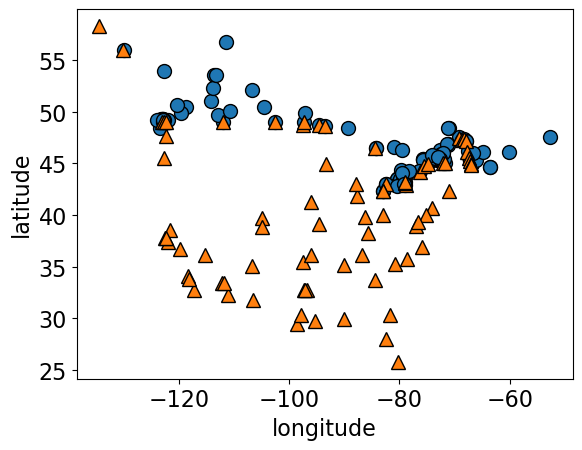

In [8]:
mglearn.discrete_scatter(X_cities.iloc[:, 0], X_cities.iloc[:, 1], y_cities)
plt.xlabel("longitude")
plt.ylabel("latitude");

In the [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home), how many dimensions does it have?


In [9]:
spotify_df = pd.read_csv("../data/spotify.csv", index_col=0)
X_spotify = spotify_df.drop(columns=["target", "song_title", "artist"])
X_spotify.head()


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


In [10]:
print("The number of features in the Spotify dataset: %d" % X_spotify.shape[1])

The number of features in the Spotify dataset: 13


The [mnist dataset](https://en.wikipedia.org/wiki/MNIST_database#cite_note-1) is an important (but basic) computer vision dataset
- Characters 0 to 9
- You can develop a solution for MNIST in 5 minutes with 99% accuracy :)
- Each image is **128 x 128** pixels (????)
- **Classification** problem


<img src="https://storage.googleapis.com/tfds-data/visualization/fig/mnist-3.0.1.png" width="300"> <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="500">


**Question for you:**
Number of features in MNIST dataset?

### Dimensions in ML problems 

Very naively put (**don't quote me on this**):

- $d \approx 20$ is considered low dimensional
- $d \approx 1000$ is considered medium dimensional 
- $d \approx 100,000$ is considered high dimensional 
  - If you have an image input of `1024 x 768`, that's a 800k dimension feature space.

### Feature vectors 

**Feature vector**
: is composed of feature values associated with an example.

Some example feature vectors are shown below. 

In [11]:
print(
    "An example feature vector from the Spotify dataset: \n\n%s"
    % (X_spotify.iloc[0].to_numpy())
)

X_spotify.head()

An example feature vector from the Spotify dataset: 

[ 1.02000e-02  8.33000e-01  2.04600e+05  4.34000e-01  2.19000e-02
  2.00000e+00  1.65000e-01 -8.79500e+00  1.00000e+00  4.31000e-01
  1.50062e+02  4.00000e+00  2.86000e-01]


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904


### Similarity between examples

Let's take 2 points (two feature vectors) from the cities dataset.

In [13]:
two_cities = X_cities.sample(2, random_state=120)
two_cities

,longitude,latitude
69,-104.8253,38.8340
35,-112.0741,33.4484


The two sampled points are shown as big black circles.

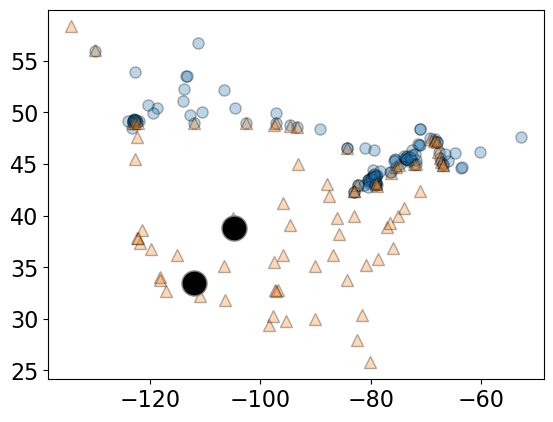

In [14]:
mglearn.discrete_scatter(
    X_cities.iloc[:, 0], X_cities.iloc[:, 1], y_cities, s=8, alpha=0.3
)
mglearn.discrete_scatter(
    two_cities.iloc[:, 0], two_cities.iloc[:, 1], markers="o", c="k", s=18
);

## Similarity Metrics and Similarity Criterions

### Euclidean distance 

$distance(u, v) = \sqrt{\sum_{i =1}^{n} (u_i - v_i)^2}$  
$u = <u_1, u_2, \dots, u_n>$
$v = <v_1, v_2, \dots, v_n>$

where
- $u$, $v$ are feature vectors of two samples
- $n$ is the dimensionality of data


For the cities, **Euclidean Distance** makes a lot of sense.

For the cities at the two big circles, what is the _distance_ between them?

In [ ]:
two_cities

- Subtract the two cities
- Square the difference
- Sum them up 
- Take the square root 

In [15]:
# Subtract the two cities
print("Subtract the cities: \n%s\n" % list((two_cities.iloc[1] - two_cities.iloc[0])))

# Squared sum of the difference
print(
    "Sum of squares: %0.4f" % (np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2))
)

# Take the square root
print(
    "Euclidean distance between cities: %0.4f"
    % (np.sqrt(np.sum((two_cities.iloc[1] - two_cities.iloc[0]) ** 2)))
)

Subtract the cities: 
[-7.248800000000003, -5.385600000000004]

Sum of squares: 81.5498
Euclidean distance between cities: 9.0305


In [16]:
# Euclidean distance using sklearn
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances(two_cities)

array([[0.        , 9.03049217],
       [9.03049217, 0.        ]])

In [17]:
import sklearn
sklearn.metrics.pairwise_distances(two_cities, metric='euclidean')

array([[0.        , 9.03049217],
       [9.03049217, 0.        ]])

In [18]:
sklearn.metrics.pairwise_distances(two_cities, metric='l1')

array([[ 0.    , 12.6344],
       [12.6344,  0.    ]])


### Other Similarity Metrics
Note: `scikit-learn` supports a number of other [distance metrics](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html).

In the order I expect you to prioritize learning them:
- euclidean (l2)
- manhattan (l1) (cityblock) (sum of absolute distances: ${\sum_{i =1}^{n}|u_i - v_i|}$  
- **cosine**
- mahalanobis
- haversine (angular distance between two points on a surface of a sphere)
- and a few more (chebyshev, minkowski, wminkowski, seuclidean, ...)

Check scikit-learn to learn more:
-  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html

### Finding the nearest neighbour of City 0

- Let's look at distances from all cities to all other cities

In [20]:
X_cities

,longitude,latitude
0,-130.0437,55.9773
1,-134.4197,58.3019
2,-123.0780,48.9854
3,-122.7436,48.9881
4,-122.2691,48.9951
...,...,...
204,-72.7218,45.3990
205,-66.6458,45.9664
206,-79.2506,42.9931
207,-72.9406,45.6275


In [21]:
dists = euclidean_distances(X_cities)
dists.shape

(209, 209)

In [22]:
pd.DataFrame(dists)

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,0.000000,4.955113,9.869531,10.106452,10.449666,19.381676,28.366626,33.283857,33.572105,36.180388,...,9.834455,58.807684,16.925593,56.951696,59.384127,58.289799,64.183423,52.426410,58.033459,51.498562
1,4.955113,0.000000,14.677579,14.935802,15.305346,24.308448,33.200978,38.082949,38.359992,40.957919,...,14.668787,63.533498,21.656349,61.691640,64.045304,63.032656,68.887343,57.253724,62.771969,56.252160
2,9.869531,14.677579,0.000000,0.334411,0.808958,11.115406,20.528403,25.525757,25.873103,28.479109,...,0.277381,51.076798,10.783789,49.169693,51.934205,50.483751,56.512897,44.235152,50.249720,43.699224
3,10.106452,14.935802,0.334411,0.000000,0.474552,10.781004,20.194002,25.191396,25.538702,28.144750,...,0.275352,50.743133,10.480249,48.836189,51.599860,50.150395,56.179123,43.904226,49.916254,43.365623
4,10.449666,15.305346,0.808958,0.474552,0.000000,10.306500,19.719500,24.716985,25.064200,27.670344,...,0.675814,50.269880,10.051472,48.363192,51.125476,49.677629,55.705696,43.435186,49.443317,42.892477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,58.289799,63.032656,50.483751,50.150395,49.677629,39.405415,30.043890,25.057003,24.746328,22.127878,...,50.333340,0.873356,41.380643,1.345136,3.373031,0.000000,6.102435,6.957987,0.316363,6.800190
205,64.183423,68.887343,56.512897,56.179123,55.705696,45.418031,36.031385,31.032874,30.709185,28.088948,...,56.358333,5.442806,47.259286,7.369875,5.108681,6.102435,0.000000,12.950733,6.303916,12.819584
206,52.426410,57.253724,44.235152,43.904226,43.435186,33.258427,24.059863,19.187663,18.932124,16.380495,...,44.100248,7.767852,35.637982,5.930561,9.731583,6.957987,12.950733,0.000000,6.837848,3.322755
207,58.033459,62.771969,50.249720,49.916254,49.443317,39.167214,29.799983,24.810368,24.497386,21.878183,...,50.098326,0.930123,41.121628,1.082749,3.286821,0.316363,6.303916,6.837848,0.000000,6.555740


In [23]:
np.fill_diagonal(dists, np.inf)
pd.DataFrame(dists)

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,inf,4.955113,9.869531,10.106452,10.449666,19.381676,28.366626,33.283857,33.572105,36.180388,...,9.834455,58.807684,16.925593,56.951696,59.384127,58.289799,64.183423,52.426410,58.033459,51.498562
1,4.955113,inf,14.677579,14.935802,15.305346,24.308448,33.200978,38.082949,38.359992,40.957919,...,14.668787,63.533498,21.656349,61.691640,64.045304,63.032656,68.887343,57.253724,62.771969,56.252160
2,9.869531,14.677579,inf,0.334411,0.808958,11.115406,20.528403,25.525757,25.873103,28.479109,...,0.277381,51.076798,10.783789,49.169693,51.934205,50.483751,56.512897,44.235152,50.249720,43.699224
3,10.106452,14.935802,0.334411,inf,0.474552,10.781004,20.194002,25.191396,25.538702,28.144750,...,0.275352,50.743133,10.480249,48.836189,51.599860,50.150395,56.179123,43.904226,49.916254,43.365623
4,10.449666,15.305346,0.808958,0.474552,inf,10.306500,19.719500,24.716985,25.064200,27.670344,...,0.675814,50.269880,10.051472,48.363192,51.125476,49.677629,55.705696,43.435186,49.443317,42.892477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,58.289799,63.032656,50.483751,50.150395,49.677629,39.405415,30.043890,25.057003,24.746328,22.127878,...,50.333340,0.873356,41.380643,1.345136,3.373031,inf,6.102435,6.957987,0.316363,6.800190
205,64.183423,68.887343,56.512897,56.179123,55.705696,45.418031,36.031385,31.032874,30.709185,28.088948,...,56.358333,5.442806,47.259286,7.369875,5.108681,6.102435,inf,12.950733,6.303916,12.819584
206,52.426410,57.253724,44.235152,43.904226,43.435186,33.258427,24.059863,19.187663,18.932124,16.380495,...,44.100248,7.767852,35.637982,5.930561,9.731583,6.957987,12.950733,inf,6.837848,3.322755
207,58.033459,62.771969,50.249720,49.916254,49.443317,39.167214,29.799983,24.810368,24.497386,21.878183,...,50.098326,0.930123,41.121628,1.082749,3.286821,0.316363,6.303916,6.837848,inf,6.555740


Let's look at the distances between **City 0** and some other cities. 

Which city is the closest to **City 0** based on the **Euclidean Distance**?

In [27]:
print(dists[0][81])
dists[0].argmin()

0.06540068802871671


81

In [28]:
# Uncomment the following if to learn more details
# print("Feature vector for city 0: \n%s\n" % (X_cities.iloc[0]))
# print("Distances from city 0 to the first 5 cities: %s" % (dists[0][:5]))

# We can find the closest city with `np.argmin`:
print(
    "The closest city from city 0 is: %d \n\nwith feature vector: \n%s"
    % (np.argmin(dists[0]), X_cities.iloc[np.argmin(dists[0])])
)

The closest city from city 0 is: 81 

with feature vector: 
longitude   -129.9912
latitude      55.9383
Name: 81, dtype: float64


**Question**

- Would we get the same results if we used a different metric (example, `l1` or `haversine`)?

In [34]:
# sklearn.metrics.pairwise_distances(X_cities, metric='l1')[0][1:].argmin() + 1
sklearn.metrics.pairwise_distances(X_cities, metric='haversine')[0][1:].argmin() + 1

146

### Finding the nearest neighbor of a query point (city)

We can also find the distances to a new "test" or "query" city:

In [36]:
# Let's find a city that's closest to the a query city
query_point = [[-80, 25]]

dists = euclidean_distances(X_cities, query_point)
print(dists.shape)
dists[0:10]

(209, 1)


array([[58.85545875],
       [63.80062924],
       [49.30530902],
       [49.01473536],
       [48.60495488],
       [39.96834506],
       [32.92852376],
       [29.53520104],
       [29.52881619],
       [27.84679073]])

In [37]:
# The query point is closest to
print(
    "The query point %s is closest to the city with index %d and the distance between them is: %0.4f"
    % (query_point, np.argmin(dists), dists[np.argmin(dists)])
)

The query point [[-80, 25]] is closest to the city with index 72 and the distance between them is: 0.7982


<br><br>

# $k$-Nearest Neighbours ($k$-NNs) [[video](https://youtu.be/bENDqXKJLmg)]

Evelyn Fix and Joseph Hodges are credited with the initial ideas around the KNN model [in this 1951 paper](https://apps.dtic.mil/sti/pdfs/ADA800276.pdf),  
while Thomas Cover expands on their concept in [his research](https://isl.stanford.edu/~cover/papers/transIT/0021cove.pdf) “Nearest Neighbor Pattern Classification.”
> Reference: https://www.ibm.com/topics/knn

In [38]:
small_cities = cities_df.sample(30, random_state=90)
one_city = small_cities.sample(1, random_state=44)
small_train_df = pd.concat([small_cities, one_city]).drop_duplicates(keep=False)

In [39]:
X_small_cities = small_train_df.drop(columns=["country"]).to_numpy()
y_small_cities = small_train_df["country"].to_numpy()
test_point = one_city[["longitude", "latitude"]].to_numpy()

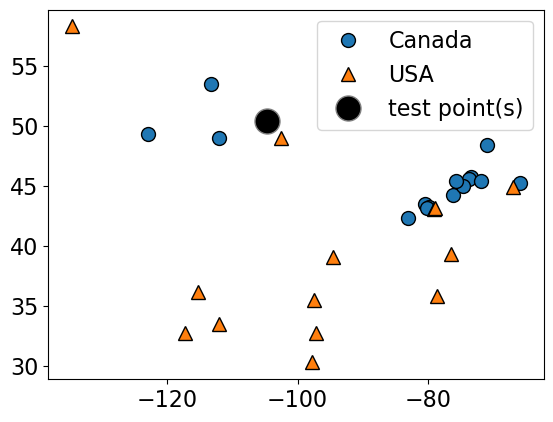

In [40]:
plot_train_test_points(
    X_small_cities,
    y_small_cities,
    test_point,
    class_names=["Canada", "USA"],
    test_format="circle",
)

- Given a new data point, predict the class of the data point by finding the "closest" data point in the training set, i.e., by finding its "nearest neighbour" or majority vote of nearest neighbours. 

Suppose we want to predict the class of the black point.  
- An intuitive way to do this is predict the same label as the "closest" point ($k = 1$) (1-nearest neighbour)
- We would predict a target of **USA** in this case.

n_neighbors 1


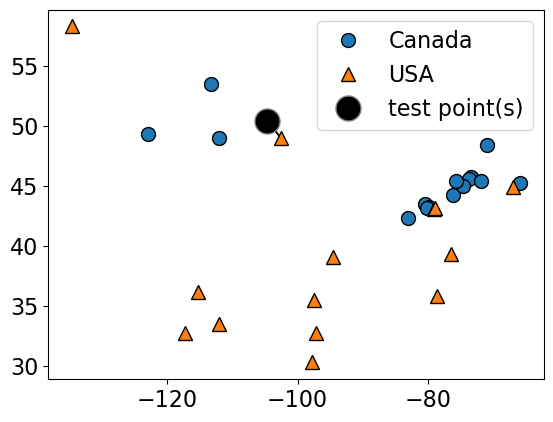

In [41]:
plot_knn_clf(
    X_small_cities,
    y_small_cities,
    test_point,
    n_neighbors=1,
    class_names=["Canada", "USA"],
    test_format="circle",
)

How about using $k > 1$ to get a more robust estimate? 
- For example, we could also use the 3 closest points (*k* = 3) and let them **vote** on the correct class.  
- The **Canada** class would win in this case. 

n_neighbors 3


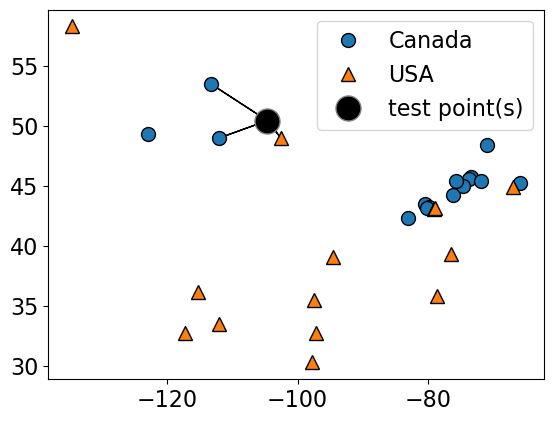

In [42]:
plot_knn_clf(
    X_small_cities,
    y_small_cities,
    test_point,
    n_neighbors=3,
    class_names=["Canada", "USA"],
    test_format="circle",
)

In [43]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 3, 5]
for k in k_values:

    # ---- New function ------
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_small_cities, y_small_cities)
    # -----------------------
    
    print(
        "Prediction of the black dot with %d neighbours: %s"
        % (k, neigh.predict(test_point))
    )

Prediction of the black dot with 1 neighbours: ['USA']
Prediction of the black dot with 3 neighbours: ['Canada']
Prediction of the black dot with 5 neighbours: ['USA']


<br><br><br><br><br><br>
In the KNN algorithm, `k` matters!

is `k` a **hyper-parameter** or **parameter**?

Hyper-parameter
<br><br><br><br><br><br>

## Choosing `n_neighbors`

- The primary hyperparameter of the model is `n_neighbors` ($k$) which decides how many neighbours should vote during prediction? 
- What happens when we play around with `n_neighbors`?
- Are we more likely to **overfit** with a low `n_neighbors` or a high `n_neighbors`?
- Let's examine the effect of the hyperparameter on our cities data. 

In [44]:
from sklearn.model_selection import train_test_split, cross_validate

X = cities_df.drop(columns=["country"])
y = cities_df["country"]

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.9, random_state=123
)

# split train into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=0.8, random_state=123
)

In [45]:
k = 1
knn1 = KNeighborsClassifier(n_neighbors=k)
score = knn1.fit(X_train, y_train).score(X_valid, y_valid)
print('Validation Accuracy:', score)

Validation Accuracy: 0.7894736842105263


In [46]:
k = 10
knn100 = KNeighborsClassifier(n_neighbors=k)
score = knn100.fit(X_train, y_train).score(X_valid, y_valid)
print('Validation Accuracy:', score)

Validation Accuracy: 0.8421052631578947


In [47]:
k = 20
knn20 = KNeighborsClassifier(n_neighbors=k)
score = knn20.fit(X_train, y_train).score(X_valid, y_valid)
print('Validation Accuracy:', score)

Validation Accuracy: 0.8157894736842105


In [ ]:
# For students: Play around with this for fun!
# ------------- To be skipped ----------------
def f(n_neighbors=1):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    score_valid = knn.score(X_valid, y_valid)
    score_train = knn.score(X_train, y_train)
    print('n_neighbors:', n_neighbors)
    print('train score:', score_train)
    print('valid score:', score_valid)

interactive(
    f,
    n_neighbors=widgets.IntSlider(min=1, max=101, step=5, value=1),
)
# ------------- To be skipped ----------------

/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/amirabdi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


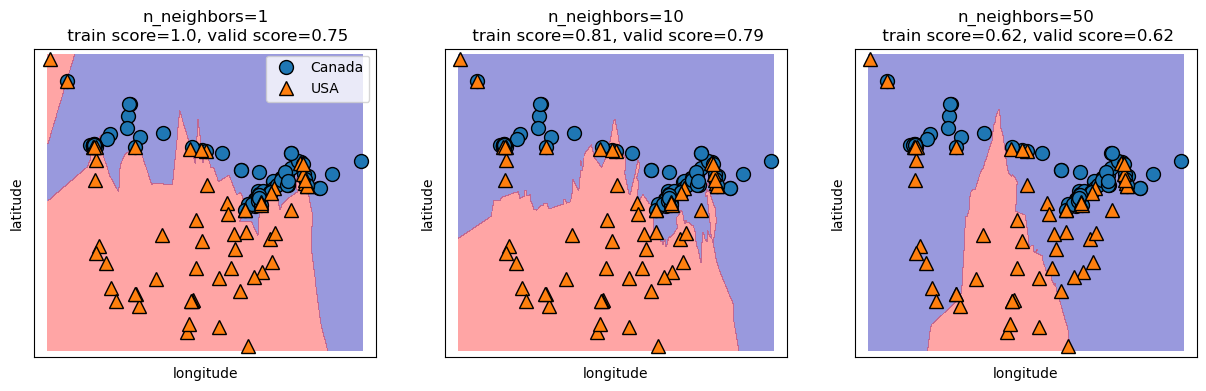

In [48]:
import matplotlib
from plotting_functions import plot_knn_decision_boundaries
matplotlib.rc('font', **{'size'   : 10})

plot_knn_decision_boundaries(X_train, y_train, k_values=[1, 10, 20])

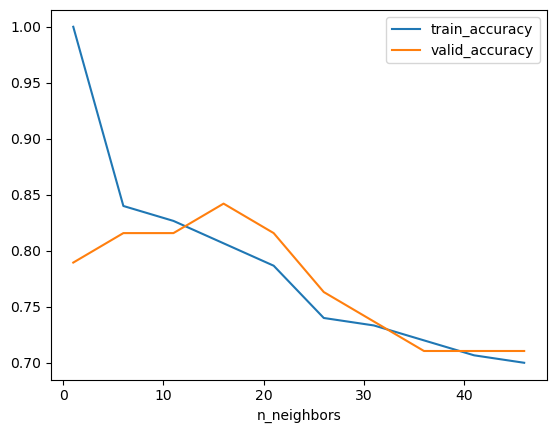

In [49]:
scores_valid, scores_train = list(), list()

n_neighbors_list = range(1, 50, 5)
for n_neighbors in n_neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    
    scores_valid.append(knn.score(X_valid, y_valid))
    scores_train.append(knn.score(X_train, y_train))

results_df = pd.DataFrame({'train_accuracy': scores_train, 'valid_accuracy': scores_valid, 'n_neighbors': n_neighbors_list}).set_index('n_neighbors')
results_df.plot();

<br><br><br><br>
**Question**:
Why at `n_neighbors=1`, Train Accuracy is 100%?
<br><br><br><br><br><br><br><br><br><br>

## What's the performance of the best model on test set?

- `n_neighbors` is a hyperparameter
- We can use hyperparameter optimization to choose `n_neighbors`.

In [51]:
results_df

,train_accuracy,valid_accuracy
n_neighbors,,
1,1.000000,0.789474
6,0.840000,0.815789
11,0.826667,0.815789
16,0.806667,0.842105
21,0.786667,0.815789
26,0.740000,0.763158
31,0.733333,0.736842
36,0.720000,0.710526
41,0.706667,0.710526


In [53]:
results_df.idxmax()

train_accuracy     1
valid_accuracy    16
dtype: int64

**Question**: Do you notice some weird pattern above? How do you explain that?

------------------
Now, we will evaluate our best model on **test data** to report to our stakeholders (customer, product manager, marketting, etc.):

In [54]:
pd.concat((y_train, y_valid))

203    Canada
125    Canada
110    Canada
53        USA
128    Canada
        ...  
169    Canada
104    Canada
129    Canada
94     Canada
131    Canada
Name: country, Length: 188, dtype: object

In [55]:
best_n_neighbours = results_df.idxmax()['valid_accuracy']
knn = KNeighborsClassifier(n_neighbors=best_n_neighbours)

# Let's use the entire Train + Valid dataset to train a new model
knn.fit(pd.concat((X_train, X_valid)), pd.concat((y_train, y_valid)))

print("Test accuracy: %0.3f" % (knn.score(X_test, y_test)))

Test accuracy: 0.857


<br><br>

## ❓❓ Questions for you 

### (iClicker) Exercise 4.1 

**iClicker cloud join link: https://join.iclicker.com/EMMJ**

**Select all of the following statements which are TRUE.**

1. Similarity (analogy)-based models find examples from the **test set** that are most similar to the query example we are predicting.
2. We more likely to **overfit** with a low `n_neighbors` than a high `n_neighbors` --> debatable, but, if have to answer, I'd say: FALSE
3. With $k$-NN, setting the hyperparameter $k$ to larger values typically reduces training error. 
4. In $k$-NN, with $k > 1$, the classification of the closest neighbour to the test example always contributes the most to the prediction.
5. KNN is such an old algorithm, oh dear! Why am I learning this? :)

## Break (5 min)

![](../img/eva-coffee.png)


<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
```python
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
```
What's KNN learning when we call the `.fit()` function?
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

- **Lazy learning**: Takes no time to `fit`, i.e, **no fitting!** 
- There is no learning happening
- Has no learning process
- model = all the training data

Compuational complexity of prediction on a new sample? 

- Have to **iterate** over all the sample one-by-one and calculate the **distance** to all, and get the **top k** samples.
- Can be potentially be **VERY slow** during prediction time, especially when the training set is very large.

<br><br><br><br><br><br><br><br><br><br>

## [Study on your own!]
### More on $k$-NNs [[video](https://youtu.be/IRGbqi5S9gQ)]

### Other useful arguments of `KNeighborsClassifier`

- `weights` $\rightarrow$ When predicting label, **you can assign higher weight to the examples which are closer to the query example**.  
- **Exercise for you**: Play around with this argument. Do you get a better validation score? 

### Regression with $k$-nearest neighbours ($k$-NNs)

- Can we solve regression problems with $k$-nearest neighbours algorithm? 
- In $k$-NN regression we take the average of the $k$-nearest neighbours. 
- We can also have **weighted regression**. 

See an example of regression in the lecture notes. 

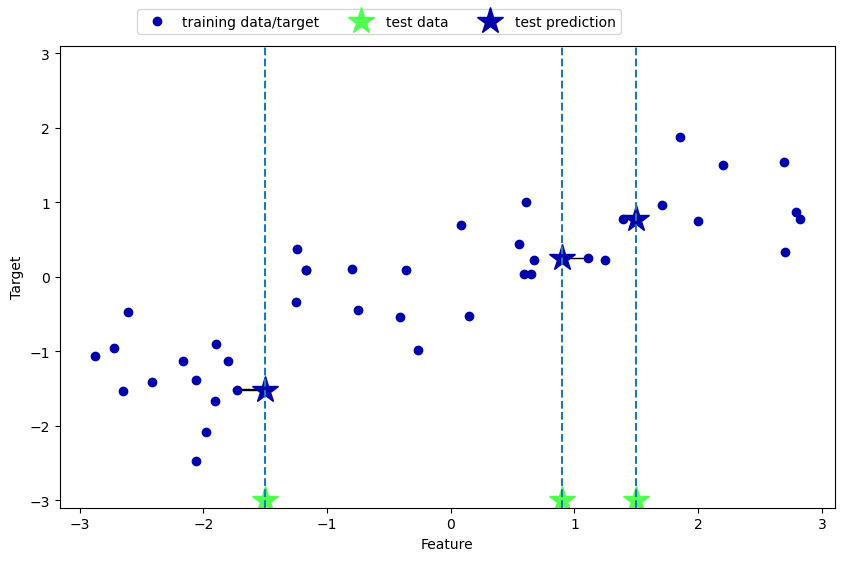

In [56]:
mglearn.plots.plot_knn_regression(n_neighbors=1)

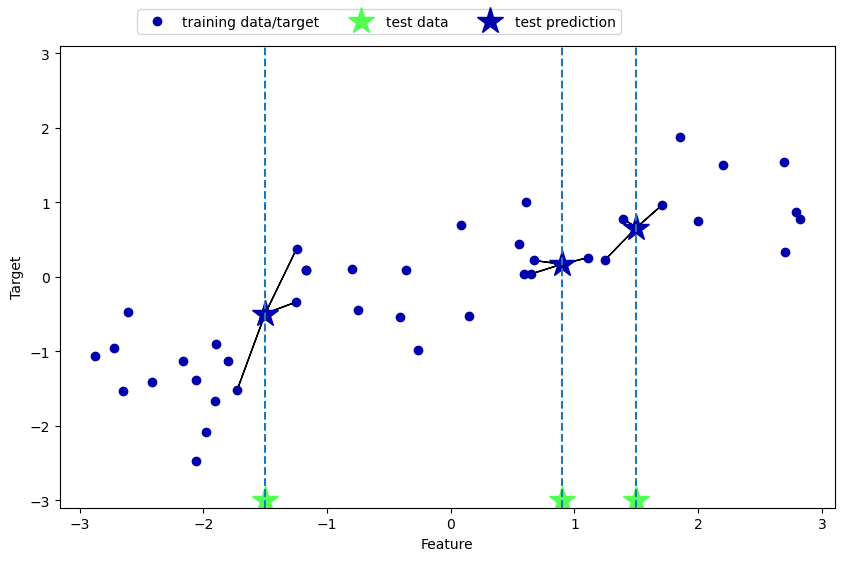

In [57]:
mglearn.plots.plot_knn_regression(n_neighbors=3)

### Pros of $k$-NNs for supervised learning

- Easy to understand, interpret.
- Simple hyperparameter $k$ (`n_neighbors`) controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.

### Cons of $k$-NNs for supervised learning

- Can be potentially be VERY slow during prediction time, especially when the training set is very large. 
- Often not that great test accuracy compared to the modern approaches.
- It does not work well on datasets with many features or where most feature values are 0 most of the time (sparse datasets).    


For regular $k$-NN for supervised learning (not with sparse matrices), you should normalize (scale) your features.   
We'll be looking into it soon. 


# Parametric vs Non-parametric Models

- **Parametric Model:** Learning **finite number of learnable parameters** during training.
  - Eventually, as we add more data, we get to a point where more data doesn’t help (too much bias, model is too simple).
- **Non-parametric Model:** The number of **parameters can be potentially infinite**.

A simplied explanation of **non-parametric model**: The model (what is stored with the model) **increases with the size of data**



**Non-parametric example**: $k$-NN is a classic example of non-parametric models.     

**Question**: Are **DecisionTrees** parametric or non-parametric?

Answer: Non-Parametric (in general)



- If you want to know more about this, find some reading material 
  - https://www.cs.ubc.ca/~schmidtm/Courses/340-F16/L6.pdf
  - http://mlss.tuebingen.mpg.de/2015/slides/ghahramani/gp-neural-nets15.pdf
  - https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/
- By the way, the terms "parametric" and "non-paramteric" are often used differently by statisticians, see [here](https://help.xlstat.com/s/article/what-is-the-difference-between-a-parametric-and-a-nonparametric-test?language=en_US) for more...

<br><br><br><br><br><br><br><br>
# Curse of dimensionality

**When more features HARM rather than HELP**

- Affects all learners but especially bad for similarity-based models. 

## Curse of Dimensionality on KNN

- $k$-NN usually works well when the number of dimensions $d$ is small but things fall apart quickly as $d$ goes up.
  - **Because $k$-NN cannot ignore any features**
- If there are many irrelevant attributes, $k$-NN is hopelessly confused because all of them contribute to finding similarity between examples. 
- With enough irrelevant attributes the accidental similarity swamps out meaningful similarity and $k$-NN is no better than random guessing.  

In [58]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=30, n_features=4, n_classes=2)
X

array([[-0.15836572,  0.01677597, -0.15846676,  0.14258461],
       [ 1.43015811,  2.47607029, -1.8062561 ,  1.93564619],
       [ 1.39572448, -0.02695912,  1.24766795, -1.10833963],
       [ 1.49930647,  2.62557045, -1.93028184,  2.06576886],
       [-1.92370042, -2.93048388,  1.93667871, -2.11285816],
       [-2.56572306, -4.06837461,  2.7799908 , -3.01411497],
       [-1.25845821, -0.37249584, -0.63607637,  0.51257052],
       [-0.58369299, -0.32959233, -0.10180704,  0.04536086],
       [-0.5356727 , -0.27498415, -0.12730409,  0.07535485],
       [ 0.7650448 ,  1.36186022, -1.01221176,  1.08122797],
       [-2.80648029,  0.2453873 , -2.74431664,  2.46313815],
       [ 1.32930463,  2.25512203, -1.62178929,  1.74230247],
       [ 2.25536343,  0.07813046,  1.86618321, -1.64169148],
       [ 1.28954873,  2.15602639, -1.53428993,  1.65136797],
       [-0.92223374,  0.16328704, -1.00363689,  0.91079765],
       [-0.63762337, -0.13114785, -0.3932289 ,  0.33034452],
       [-1.24215825, -2.

```python
from sklearn.dummy import DummyClassifier
```
Randomly selects one of the two classes; it's expected accuracy is 50% on binary classification

In [59]:
from sklearn.dummy import DummyClassifier
from sklearn.datasets import make_classification

nfeats_accuracy = {"nfeats": [], "dummy_valid_accuracy": [], "KNN_valid_accuracy": []}
for n_feats in range(4, 2000, 100):
    X, y = make_classification(n_samples=2000, n_features=n_feats, n_classes=2)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    # DummyClassifier 
    dummy = DummyClassifier(strategy="most_frequent")
    dummy_scores = cross_validate(dummy, X_train, y_train, return_train_score=True)

    # KNeighborsClassifier 
    knn = KNeighborsClassifier()
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    
    nfeats_accuracy["nfeats"].append(n_feats)
    nfeats_accuracy["KNN_valid_accuracy"].append(np.mean(scores["test_score"]))
    nfeats_accuracy["dummy_valid_accuracy"].append(np.mean(dummy_scores["test_score"]))

In [60]:
pd.DataFrame(nfeats_accuracy)

,nfeats,dummy_valid_accuracy,KNN_valid_accuracy
0,4,0.506250,0.940000
1,104,0.510625,0.781250
2,204,0.511875,0.668125
3,304,0.501875,0.652500
4,404,0.500000,0.686250
5,504,0.505000,0.614375
6,604,0.502500,0.581875
7,704,0.500625,0.600625
8,804,0.503125,0.617500
9,904,0.502500,0.633125


<br><br>

# Support Vector Machines (SVMs) with RBF kernel [[video](https://youtu.be/ic_zqOhi020)]


<img src="https://datascience.columbia.edu/wp-content/uploads/2020/08/Vapnik_web.png" width="300">

Vladimir N. Vapnik, 1936 (age 86)

> The original SVM algorithm was invented by **Vladimir N. Vapnik** and Alexey Ya. Chervonenkis** in 1963.   
In 1992, **Bernhard Boser, Isabelle Guyon and Vladimir Vapnik** suggested a way to create nonlinear classifiers by applying the kernel trick to maximum-margin hyperplanes.

- Very high-level overview
- Our goals here are
    - Use `scikit-learn`'s SVM model. 
    - Broadly explain the notion of support vectors.  
    - Broadly explain the similarities and differences between $k$-NNs and SVM RBFs.
    - Explain how `C` and `gamma` hyperparameters control the fundamental tradeoff.
    
> (Optional) RBF stands for radial basis functions. We won't go into what it means in this session. Refer to [this video](https://www.youtube.com/watch?v=Qc5IyLW_hns) if you want to know more. 

## What is a Support Vector?

Samples on the **boundaries** that determine the **margin hyperplane**


A **hyperplane** can be defined as: 

${\displaystyle \mathbf {w} ^{\mathsf {T}}\mathbf {x} -b=0}$

$w$ and $b$ are learnable parameters, and learned during training of SVM
<br><br><br><br><br>

This is is a **Linear HARD SVM** 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/1920px-SVM_margin.png" width="500">

[img source](https://en.wikipedia.org/wiki/Support_vector_machine)

**HARD**: No misclassification can happen  
**SOFT**: Misclassification can happen, and each miscalssification will be penalized relative to `C`


Check this interactive demo: https://greitemann.dev/svm-demo

## Overview

- Another popular similarity-based algorithm is Support Vector Machines with RBF Kernel (SVM RBFs)
- Superficially, SVM RBFs are more like weighted $k$-NNs.
    - The decision boundary is defined by **a set of positive and negative examples** and **their weights** together with **their similarity measure**. 

- The primary difference between $k$-NNs and SVM RBFs is that 
    - Unlike $k$-NNs, SVM RBFs only remember the key examples (**support vectors**). 
    - SVMs use a different similarity metric which is called a "kernel". 
      - A popular kernel is Radial Basis Functions (RBFs)
    - They usually perform better than $k$-NNs

Check this interactive demo: https://greitemann.dev/svm-demo

#### More practice questions 

- Check out some more practice questions [here](https://ml-learn.mds.ubc.ca/en/module4).

## Summary

- We have **KNNs and SVMs as supervised learning** techniques in our toolbox.
- These are similarity (analogy)-based learners and the idea is to assign nearby points the same label.
- **Unlike decision trees, all features are equally important**
- Both can be used for **classification** or **regression** (much like the other methods we've seen).

### Coming up:

Lingering questions: 
- Are we ready to do machine learning on real-world datasets?
- What would happen if we use $k$-NNs or SVM RBFs on the spotify dataset from hw1?  
- What happens if we have missing values in our data? 
- What do we do if we have features with categories or string values?


![](../img/eva-seeyou.png)